# Modeling
ML Tasks

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
file_path = "../data/df_model01.pkl"
df = pd.read_pickle(file_path)

print(df.shape)
df.head()

(75, 36)


,buzzwordy_title,buzzwordy_organizer,days,distance,ticket_prize,rating,main_topic_Daten,main_topic_Geo,main_topic_IT,main_topic_Innovation,...,city_Passau,city_Salzburg,city_Steyr,city_Wels,city_Wien,city_Zürich,country_Austria,country_Germany,country_Slovakia,country_Switzerland
0,0,0,1,29,0,9,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,1,3,0,3,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0,1,1,0,6,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,1,1,1,0,2,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,1,0,1,1,0,2,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


__Binning__

In [3]:
bins = [10, 40, 120, 180] # SR, LNZ, SZG, VIE, >VIE

df["binned_distance"] = np.digitize(df.distance.values, bins=bins)

__Conversion for Scikit-learn__

Feature selection based on expert knowledge. Model-based hardly interpretable, at least confirmed "binned_distance" as relevant feature. 

In [4]:
feature_names = ["buzzwordy_title", "main_topic_Daten", "binned_distance"]
X = df[feature_names].values
y = df.rating.map(lambda x: 1 if x>5 else 0).values # binary target: >5 (better as all the same) was worth attending

print("X:", X.shape, "y:", y.shape)

X: (75, 3) y: (75,)


## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, 
                                                    test_size=0.5) # 50% split, small dataset size

## Modeling

Model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

linreg = LinearRegression() # Benchmark model
dec_tree = DecisionTreeClassifier() # Actual model

### Benchmark
_Linear Regression_

In [7]:
# Benchmark
linreg.fit(X_train, y_train)
print("Score (r^2): {:.3f}".format(linreg.score(X_test, y_test)))
print("Coef: {}".format(linreg.coef_))

Score (r^2): -0.220
Coef: [ 0.02485585  0.04313925  0.08000478]


=> Really bad perfomance

### Model
_Decision Tree CV_

<= Ability to visualize, hasn't performed much worse than other applied models

__Parameter Tuning__

In [8]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {"criterion": ["gini", "entropy"], 
                  "max_depth": [None, 1, 2, 3, 4, 5, 6], 
                  "min_samples_leaf": list(range(1, 14)), 
                  "max_leaf_nodes": list(range(3, 25))}

grid_search = GridSearchCV(DecisionTreeClassifier(presort=True), parameter_grid, cv=5) # 5 fold cross-val
grid_search.fit(X_train, y_train)

print("Score (Accuracy): {:.3f}".format(grid_search.score(X_test, y_test)))
print("Best Estimator: {}".format(grid_search.best_estimator_))
print("Best Parameters: {}".format(grid_search.best_params_))

Score (Accuracy): 0.632
Best Estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=5, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 2}


=> Not that good accuracy, but at least better than random draw

__Build Model__

In [9]:
model = DecisionTreeClassifier(presort=True, criterion="gini", max_depth=None, 
                               min_samples_leaf=2, max_leaf_nodes=5)
model.fit(X_train, y_train)

print("Score (Accuracy): {:.3f}".format(model.score(X_test, y_test)))

Score (Accuracy): 0.632


__Print Decision Tree__

In [10]:
from sklearn.tree import export_graphviz

export_graphviz(model, class_names=True, feature_names=feature_names,
                rounded=True, filled=True, label="root", impurity=False, proportion=True,
                out_file="plots/dectree_Model_best.dot")

## Model Evaluation

__Evaluation Scores__

In [11]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.77      0.74        26
          1       0.40      0.33      0.36        12

avg / total       0.62      0.63      0.62        38



=> Not so good in predicting class 1 ("worth attending), better in predicting class 0. Weighted average of precision and recall 0.62 (F1 Score)

__ROC Curve__

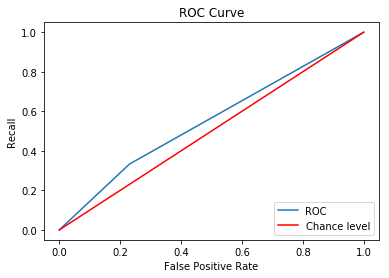

AUC: 0.551


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], c="r", label="Chance level")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("Recall")
plt.legend(loc=4)

plt.savefig("plots/ROC_Curve_Model.png", dpi=180)
plt.show()

print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))

=> Indeed only slightly better than random guess, ~ 0.05 percentage points (AUC)

In [13]:
from sklearn.model_selection import cross_val_score

scores_benchmark = cross_val_score(model, X, y, cv=5) # 5 folds

print("Cross-Val Scores (Accuracy): {}".format(scores_benchmark))
print("Cross-Val Mean (Accuracy): {}".format(scores_benchmark.mean()))

Cross-Val Scores (Accuracy): [ 0.5625      0.625       0.46666667  0.71428571  0.64285714]
Cross-Val Mean (Accuracy): 0.6022619047619048


=> Generalization acceptable, but not good (as expected from a Decision Tree)

## Persist Model

In [14]:
from sklearn.externals import joblib

file_path = "../data/model_trained.pkl"

joblib.dump(model, file_path)

['../data/model_trained.pkl']